In [85]:
# --- Importar librerías necesarias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# --- Cargar dataset ---
data = pd.read_csv('../2. Limpieza de datos/airline_passenger_satisfaction_clean.csv')
dictionary = pd.read_csv('../1. DataSet/data_dictionary.csv')
custom_palette = {
    'Neutral or Dissatisfied': '#5BAEB7',  # azul verdoso
    'Satisfied': '#3B528B'                 # azul más oscuro
}

In [87]:
def analizar_una_variable(variable):
    if pd.api.types.is_numeric_dtype(data[variable]):
        # Gráfico 1: Boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='Satisfaction', y=variable, data=data, palette=custom_palette)
        plt.title(f'Distribución de {variable} según Satisfacción (Boxplot)')
        plt.xlabel('Satisfacción')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Histograma con KDE
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=variable, hue='Satisfaction', kde=True,
                     element='step', stat='density', common_norm=False, palette=custom_palette)
        plt.title(f'Distribución de {variable} según Satisfacción (KDE)')
        plt.xlabel(variable)
        plt.ylabel('Densidad')
        plt.tight_layout()
        plt.show()

    else:
        # Gráfico 1: Barplot de proporciones
        prop_df = (
            data
            .dropna(subset=[variable, 'Satisfaction'])
            .value_counts(subset=[variable, 'Satisfaction'], normalize=True)
            .reset_index(name='Proporción')
        )

        plt.figure(figsize=(10, 6))
        sns.barplot(x=variable, y='Proporción', hue='Satisfaction', data=prop_df, palette=custom_palette)
        plt.title(f'Proporción de Satisfacción según {variable}')
        plt.xlabel(variable)
        plt.ylabel('Proporción')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Conteo total
        plt.figure(figsize=(10, 6))
        sns.countplot(x=variable, hue='Satisfaction', data=data)
        plt.title(f'Conteo de pasajeros según {variable} y Satisfacción')
        plt.xlabel(variable)
        plt.ylabel('Cantidad')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [88]:
def analizar_dos_variables(var1, var2):
    tipo1 = 'numérica' if pd.api.types.is_numeric_dtype(data[var1]) else 'categórica'
    tipo2 = 'numérica' if pd.api.types.is_numeric_dtype(data[var2]) else 'categórica'

    print(f"{var1} es {tipo1}, {var2} es {tipo2}\n")

    # Caso 1: Ambas numéricas → Scatterplot
    if tipo1 == 'numérica' and tipo2 == 'numérica':
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=data, x=var1, y=var2, hue='Satisfaction', alpha=0.6, palette=custom_palette)
        plt.title(f'{var1} vs {var2} según Satisfacción')
        plt.tight_layout()
        plt.show()

    # Caso 2: Una numérica y otra categórica → Boxplot agrupado
    elif tipo1 != tipo2:
        num_var = var1 if tipo1 == 'numérica' else var2
        cat_var = var1 if tipo1 == 'categórica' else var2

        plt.figure(figsize=(12, 6))
        sns.boxplot(x=cat_var, y=num_var, hue='Satisfaction', data=data, palette=custom_palette)
        plt.title(f'{num_var} según {cat_var} y Satisfacción')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Caso 3: Ambas categóricas → Heatmap de proporciones
    elif tipo1 == 'categórica' and tipo2 == 'categórica':
        crosstab = pd.crosstab(index=data[var1], columns=[data[var2], data['Satisfaction']], normalize='index')
        crosstab = crosstab.stack().reset_index().rename(columns={0: 'Proporción'})

        plt.figure(figsize=(12, 6))
        sns.barplot(x=var2, y='Proporción', hue='Satisfaction', data=crosstab, ci=None)
        plt.title(f'Proporción de Satisfacción según {var1} y {var2}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [89]:
def heatmap_2_ordinales_vs_satisfaccion(var1, var2):
    """
    Compara dos variables ordinales agrupadas (Insatisfecho / Neutral / Satisfecho)
    y muestra un heatmap con la proporción de pasajeros satisfechos por combinación.
    Filtra los valores 'No aplica' (0 o NaN).
    """

    def categorizar(valor):
        if valor in [1, 2]:
            return 'Insatisfecho'
        elif valor == 3:
            return 'Neutral'
        elif valor in [4, 5]:
            return 'Satisfecho'
        else:
            return None  # Así se eliminan los "No aplica" (0 o NaN)

    # Crear nuevas columnas categorizadas sin "No aplica"
    df = data[[var1, var2, 'Satisfaction']].copy()
    df[f'cat_{var1}'] = df[var1].apply(categorizar)
    df[f'cat_{var2}'] = df[var2].apply(categorizar)

    # Eliminar filas con valores no categorizables
    df = df.dropna(subset=[f'cat_{var1}', f'cat_{var2}'])

    # Crear tabla de conteo por combinación y calcular proporción de satisfechos
    tabla = df.groupby([f'cat_{var1}', f'cat_{var2}', 'Satisfaction']).size().unstack(fill_value=0)
    tabla['Proporción Satisfechos'] = tabla['Satisfied'] / (tabla['Satisfied'] + tabla['Neutral or Dissatisfied'])

    # Transformar para heatmap
    heatmap_data = tabla['Proporción Satisfechos'].unstack()

    # Gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', fmt='.2f', vmin=0, vmax=1)
    plt.title(f'Proporción de pasajeros satisfechos según\n{var1} y {var2} (agrupados)')
    plt.xlabel(f'{var2}')
    plt.ylabel(f'{var1}')
    plt.tight_layout()
    plt.show()

C:\Users\isaac\AppData\Local\Temp\ipykernel_24408\3051581796.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Satisfaction', y=variable, data=data, palette=custom_palette)


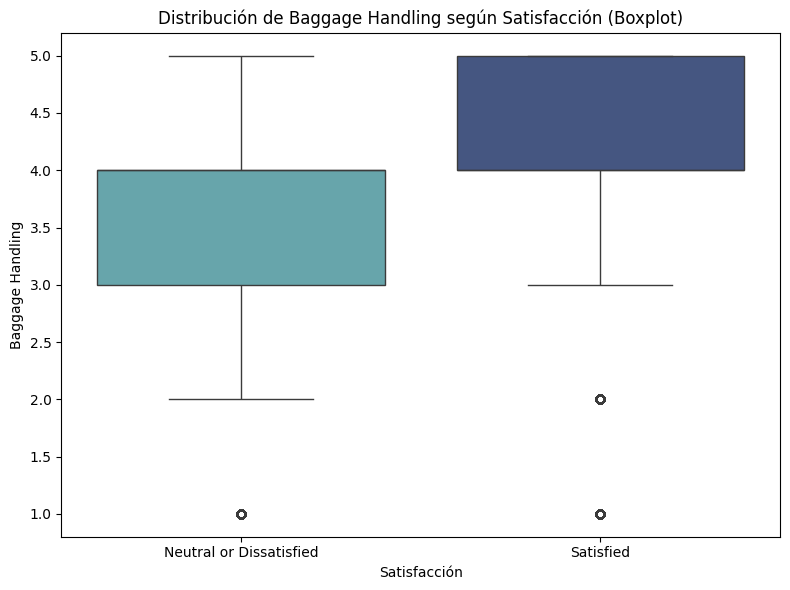

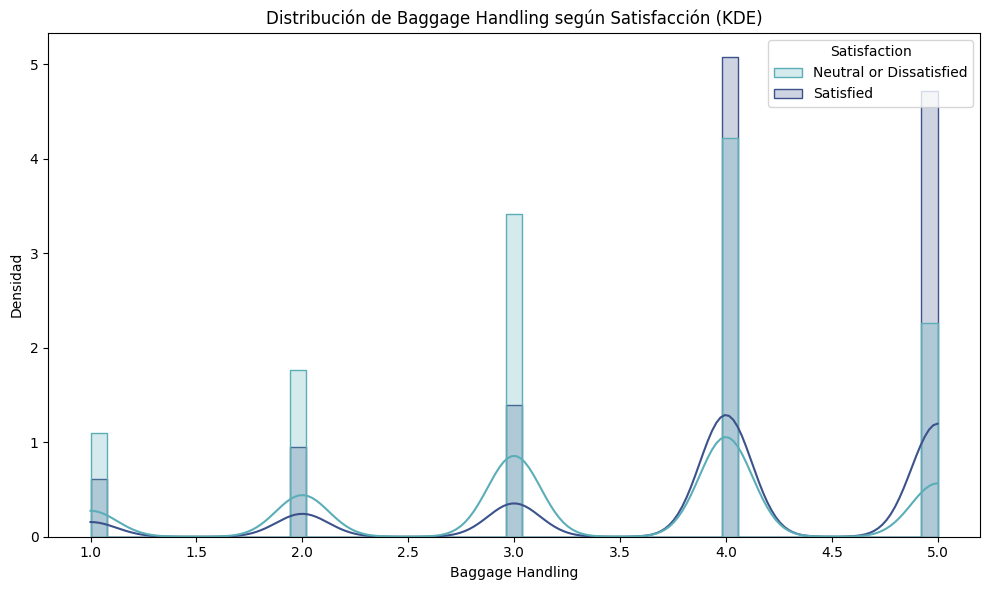

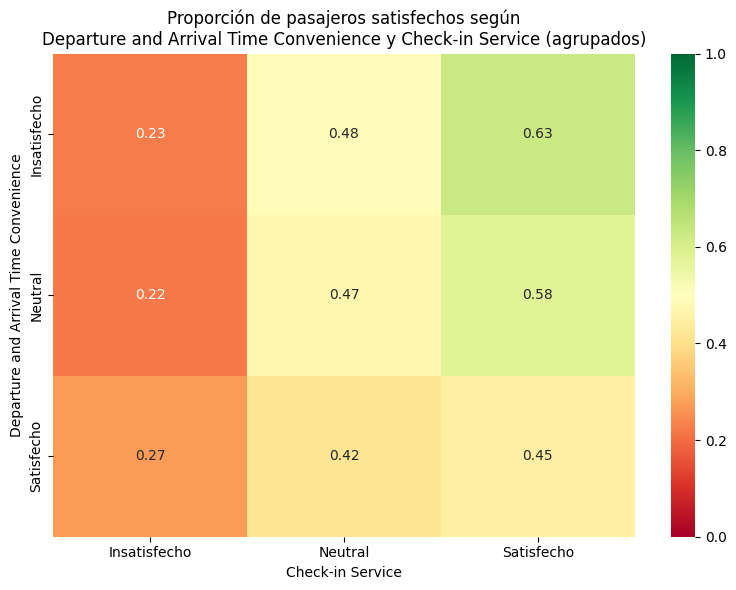

In [90]:
analizar_una_variable('Baggage Handling')
##analizar_dos_variables('Class', 'In-flight Wifi Service')
heatmap_2_ordinales_vs_satisfaccion('Departure and Arrival Time Convenience', 'Check-in Service')